# Assignment 6

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

In this assignment will be trying to identify similar question using deep learning models

https://www.kaggle.com/c/quora-question-pairs

** Observation **

- To create baseline, cosine similarity using glove vectors between questions are computed to create a classifier which resulted in 56%.
- Also in baseline, how well same question (label - 1) are abserved

- To models were implemeted:
    - Model 1: model to compute similarity with hinge loss
    - Model 2: model as binary classification problem
    
- Both the models performed better than baseline model
- Model 2 as binary classification problem performed significantly better than the other with accuary of 70%
- Model 1 resulted in accuarcy of 59%

In [280]:
# import libraries

import numpy as np
import pandas as pd

from collections import Counter
import codecs

import matplotlib.pyplot as plt

In [7]:
# load data

train_data = pd.read_csv("data/train.csv",index_col=0)
test_data = pd.read_csv("data/test_withlabels.csv",index_col=0)

In [10]:
train_data.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [11]:
test_data.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
403289,38530,375619,Can I still send direct message to someone who...,If you block someone on instagram can they sti...,0
403290,46732,356261,Is it ethical to list a minority race during c...,I ran a 8:45 for a 3 km when I was 16 years ol...,0
403291,206897,21086,Which app is the best educational app?,What are the best educational apps for Android...,1
403292,536858,536859,How are resources allocated in a market econom...,"In a free market economy, how are resources al...",0
403293,464296,536860,Is India still a British dominion?,"What is the difference between dependence, dom...",0


## Preprocess data

Note:  For word embedding, pretrained glove embedding are used of dimension 100

In [93]:
# function to clean data

def preprocess_data(text, to_lower = True):
    
    symbols = "! @ # $ % ^ & * ( ) _ - + = { } [ ] ; : \" \' < > / ? . , \\".split()
    
    for symbol in symbols:
        text = text.replace(symbol, " " + symbol + " ")
        
    if (to_lower):
        text = text.lower()
    
    return text

In [94]:
train_question1 = []
train_question2 = []
train_label = []


for question in train_data.iloc[:,2]:
    train_question1.append(preprocess_data(question))
    
for question in train_data.iloc[:,3]:
    train_question2.append(preprocess_data(question))
    
for label in train_data.iloc[:,4]:
    train_label.append(label)

In [95]:
test_question1 = []
test_question2 = []
test_label = []


for question in test_data.iloc[:,2]:
    test_question1.append(preprocess_data(question))
    
for question in test_data.iloc[:,3]:
    test_question2.append(preprocess_data(question))
    
for label in test_data.iloc[:,4]:
    test_label.append(label)

In [96]:
#Count same question in dataset

count =[value for value in Counter(train_question1 + train_question2).values()]


Counter(sorted(count,reverse=True))

Counter({1: 18872, 2: 490, 3: 42, 4: 4, 6: 1})

In [108]:
# create vocabulary for train and test data

def create_vocab(data,vocab = None):
    
    if vocab is None:
        vocab = {
            '<none>': 0,
            '<unk>': 1
        }
    else:
        vocab = vocab
    
    def update_vocab(sentence):
        for word in sentence.split():
            if word in vocab:
                continue
            vocab[word] = len(vocab)
    
    for sent in data:
            update_vocab(sent)
    
    return vocab


In [109]:
vocab = create_vocab(train_question1)
vocab = create_vocab(train_question2,vocab)
vocab = create_vocab(test_question1,vocab)
vocab = create_vocab(test_question2,vocab)

print("Vocabulary len: " + str(len(vocab)))

Vocabulary len: 16030


** Embed word using glove vectors **

In [110]:
embedding_dim = 100

In [111]:
# prepare embedding data

def get_embedding_index():
    embeddings_index = {}
    f = codecs.open('data/glove.6B.100d.txt',encoding = 'utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    
    return embeddings_index

def get_embedding_matrix(vocab):
    
    #count out of vocabulary word
    oov_count = 0
    oov = []
    
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    
    for word in vocab:
        wi = vocab[word]
        
        if word == '<none>':
            continue
        if word not in glove2vec.keys():
            #print('warning: glove OOV', word)
            embedding_matrix[wi] = np.array(glove2vec['<unk>'])
            oov_count += 1
            oov.append(word)
        else:
            embedding_matrix[wi] = np.array(glove2vec[word])
            
    
    print("Vocabulary len: " + str(len(vocab)))
    print("Out of Vocabulary len: " + str(oov_count))
    
    return embedding_matrix,oov

In [61]:
glove2vec = get_embedding_index()
glove2vec['<unk>'] = [0] *embedding_dim

In [112]:
embedding_matrix,oov = get_embedding_matrix(vocab)

Vocabulary len: 16030
Out of Vocabulary len: 1394


In [113]:
oov[:100]

['blockchain',
 'eatalo',
 'illegalise',
 'toptal',
 'pckure',
 '1month',
 'swtor',
 'hadn',
 'usmele',
 '60mg',
 'desease',
 'freegate',
 'c50',
 '\u200e',
 '“your”',
 'deuteromycota',
 'coolairshoes',
 'm335',
 'xb450',
 'a547',
 '40℅',
 'begginers',
 'asvab',
 'trevo',
 '“like”',
 'angellist',
 'venturimeter',
 'contenvania',
 'crypt8',
 '16800mah',
 'india’s',
 'aiiims',
 'vssut',
 '000k',
 'laaltain',
 'upsee',
 'cums',
 'bsit',
 'sqrt',
 'dergree',
 'qur’an',
 'zhì',
 '“ذليل”',
 'doxes',
 'languates',
 'counciling',
 'upwork',
 'student？',
 'bootcamps',
 'passout',
 'five5r',
 'unfollowed',
 'trello',
 'trunp',
 'a6600',
 'wwll',
 'soonfor',
 'pessat',
 'accoustic',
 '1800mhz',
 'excerted',
 'xerosis',
 'blackfyre',
 'malkova',
 'emoji',
 'manaphy',
 'hauntingme',
 'featue',
 'cibil',
 'kedavra',
 'jmeter',
 'tunak',
 'barvaria',
 'transcendentals',
 'officejet',
 'containg',
 'unfollow',
 '30am',
 'punreal',
 'paluvai',
 'unremoved',
 'byju',
 '1z0',
 'ntse',
 'iitans',
 'indire

** Baseline accuaracy of classification using cosine similarity **

Approach: compute average vector representation of sentence and then compute cosine similarity to classify


In [114]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_distance(w1,w2):
    return cosine_similarity(w1,w2)[0][0]

In [115]:
def vectors(sentence):
    
    #get weighted glove word vector
    
    vector = np.zeros((1,100)) 
    
    words = sentence.split()
    
    count = 0
    for word in words:
        count += 1
        vector = vector +  embedding_matrix[vocab[word]]
    
    vector = vector/count
    
    
    return vector

In [116]:
train_cos_sim = []
test_cos_sim = []

for ques1,ques2 in zip(train_question1,train_question2):
    train_cos_sim.append(cosine_distance(vectors(ques1),vectors(ques2)))

for ques1,ques2 in zip(test_question1,test_question2):
    test_cos_sim.append(cosine_distance(vectors(ques1),vectors(ques2)))

In [127]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(pd.DataFrame(train_cos_sim), pd.DataFrame(train_label))

In [138]:
y_pred = clf.predict(pd.DataFrame(test_cos_sim))

In [144]:
# positive prediction
print(len(test_label))
print(sum(test_label))
print(sum(y_pred))

1000
322
376


In [145]:
from sklearn.metrics import accuracy_score
print("Accuracy is ", accuracy_score(test_label,y_pred)*100)

Accuracy is  56.2


In [149]:
count_true_1 = 0
count_false_1 = 0


for a,b in zip(test_label,y_pred):
    if a == 1:
        if b == 1:
            count_true_1 += 1
        else:
            count_false_1 += 1
            
print("Total number of actual similar question:" + str(sum(test_label)))
print("Total number of correctly clasified similar question:" + str(count_true_1))
print("Total number of incorrectly clasified similar question:" + str(count_false_1))

Total number of actual similar question:322
Total number of correctly clasified similar question:130
Total number of incorrectly clasified similar question:192


## Build model

In [158]:
from keras import backend as K

K.set_learning_phase(1) #set learning phase

In [233]:
from keras.layers import Embedding, Input, LSTM, Dense, Bidirectional,merge,Reshape, Lambda, Dropout,concatenate, Activation, GRU,add,multiply
from keras.layers.pooling import MaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.models import Sequential, Model
from keras import optimizers

In [151]:
#constants and flags

embedding_dim = 100
max_len = 100

In [152]:
def padding(text):
    
    text_vector = [vocab[word] for word in text.split()]
    
    if len(text_vector) >= max_len:
        text_vector = text_vector[:max_len]
    else:
        text_vector =  [0] * (max_len - len(text_vector)) + text_vector
        
    return text_vector 

In [187]:
def hinge_loss(y_true, y_pred):
    y_true = y_true * 2 - 1
    y_pred = y_pred *2 - 1
    
    
    return K.mean(K.maximum(1. - y_true * y_pred, 0.), axis = -1)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def cos_distance(y):
    y_true, y_pred  = y
    def l2_normalize(x, axis):
        norm = K.sqrt(K.sum(K.square(x), axis=axis, keepdims=True))
        return K.sign(x) * K.maximum(K.abs(x), K.epsilon()) / K.maximum(norm, K.epsilon())
    y_true = l2_normalize(y_true, axis=-1)
    y_pred = l2_normalize(y_pred, axis=-1)
    
    return K.sum(y_true * y_pred, axis=-1)

In [154]:
pad_question1_train = np.array([padding(q) for q in train_question1])
pad_question2_train = np.array([padding(q) for q in train_question2])

pad_question1_test = np.array([padding(q) for q in test_question1])
pad_question2_test = np.array([padding(q) for q in test_question2])

In [168]:
train_label = np.array(train_label)

In [252]:
embedding_layer = Embedding(len(vocab),
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)

** try model 1 **

In [286]:
#build model
input_question1 = Input(shape=(max_len,))
input_question2 = Input(shape=(max_len,))

embedded_question1 = embedding_layer(input_question1)
embedded_question2 = embedding_layer(input_question2)

print(embedded_question1.shape)

shared_lstm = Bidirectional(LSTM(64,dropout=0.3))


encoded_question1 = shared_lstm(embedded_question1)
encoded_question2 = shared_lstm(embedded_question2)

print(encoded_question1.shape)

cnn_question1 = Conv1D(500,kernel_size = 2)(Reshape((128,1))(encoded_question1))
cnn_question2 = Conv1D(500,kernel_size = 2)(Reshape((128,1))(encoded_question2))

print(cnn_question1.shape)

maxpool_question1 = MaxPooling1D(127)(cnn_question1)
maxpool_question2 = MaxPooling1D(127)(cnn_question2)

maxpool_question1 = Activation('tanh')(maxpool_question1)
maxpool_question2 = Activation('tanh')(maxpool_question2)


cos_similarities = Lambda(cos_distance,output_shape=cos_dist_output_shape)([maxpool_question1,maxpool_question2])

model = Model([input_question1, input_question2], [cos_similarities])


sgd = optimizers.SGD(lr=0.3, momentum=0.8, decay=0.0001, nesterov=False)

model.compile('nadam', loss = hinge_loss)

(?, 100, 100)
(?, 128)
(?, 127, 500)


In [287]:
history = model.fit([pad_question1_train,pad_question2_train], 
          [train_label],
          epochs=10, verbose=2,batch_size = 128,shuffle = True,validation_split=0.1)

/opt/conda/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 9000 samples, validate on 1000 samples
Epoch 1/10
41s - loss: 0.7758 - val_loss: 0.7625
Epoch 2/10
31s - loss: 0.7477 - val_loss: 0.7591
Epoch 3/10
31s - loss: 0.7428 - val_loss: 0.7567
Epoch 4/10
31s - loss: 0.7323 - val_loss: 0.7241
Epoch 5/10
31s - loss: 0.6879 - val_loss: 0.7264
Epoch 6/10
31s - loss: 0.6659 - val_loss: 0.6678
Epoch 7/10
31s - loss: 0.6457 - val_loss: 0.6378
Epoch 8/10
31s - loss: 0.6360 - val_loss: 0.6403
Epoch 9/10
31s - loss: 0.6341 - val_loss: 0.6711
Epoch 10/10
31s - loss: 0.6217 - val_loss: 0.6178


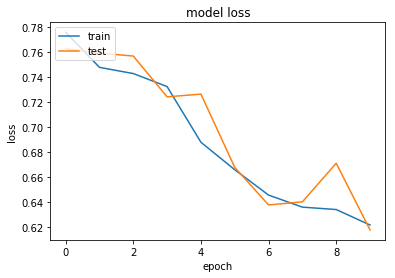

In [288]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [289]:
model_1_out_train = model.predict([pad_question1_train,pad_question2_train],verbose=2,batch_size = 128)
model_1_out_test = model.predict([pad_question1_test,pad_question2_test],verbose=2,batch_size = 128)

/opt/conda/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


In [290]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(pd.DataFrame(model_1_out_train), pd.DataFrame(train_label))
y_pred = clf.predict(pd.DataFrame(model_1_out_test))

In [291]:
from sklearn.metrics import accuracy_score
print("Accuracy is ", accuracy_score(test_label,y_pred)*100)

Accuracy is  59.4


In [292]:
count_true_1 = 0
count_false_1 = 0


for a,b in zip(test_label,y_pred):
    if a == 1:
        if b == 1:
            count_true_1 += 1
        else:
            count_false_1 += 1
            
print("Total number of actual similar question:" + str(sum(test_label)))
print("Total number of correctly clasified similar question:" + str(count_true_1))
print("Total number of incorrectly clasified similar question:" + str(count_false_1))

Total number of actual similar question:322
Total number of correctly clasified similar question:137
Total number of incorrectly clasified similar question:185


In [307]:
history = model.fit([pad_question1_train,pad_question2_train], 
          [train_label],
          epochs=10, verbose=2,batch_size = 128,shuffle = True,validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
31s - loss: 0.6230 - val_loss: 0.6377
Epoch 2/10
31s - loss: 0.6097 - val_loss: 0.6285
Epoch 3/10
31s - loss: 0.6034 - val_loss: 0.6106
Epoch 4/10
31s - loss: 0.5914 - val_loss: 0.6785
Epoch 5/10
31s - loss: 0.5898 - val_loss: 0.6161
Epoch 6/10
31s - loss: 0.5846 - val_loss: 0.6139
Epoch 7/10
30s - loss: 0.5856 - val_loss: 0.5995
Epoch 8/10
30s - loss: 0.5742 - val_loss: 0.6098
Epoch 9/10
31s - loss: 0.5690 - val_loss: 0.6120
Epoch 10/10
31s - loss: 0.5736 - val_loss: 0.6119


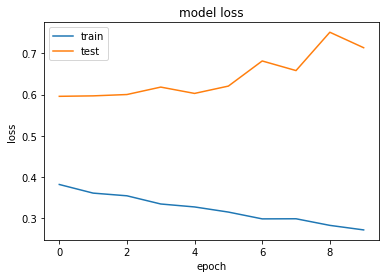

In [318]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [308]:
model_1_out_train = model.predict([pad_question1_train,pad_question2_train],verbose=2,batch_size = 128)
model_1_out_test = model.predict([pad_question1_test,pad_question2_test],verbose=2,batch_size = 128)

In [309]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(pd.DataFrame(model_1_out_train), pd.DataFrame(train_label))
y_pred = clf.predict(pd.DataFrame(model_1_out_test))

In [310]:
from sklearn.metrics import accuracy_score
print("Accuracy is ", accuracy_score(test_label,y_pred)*100)

Accuracy is  59.3


In [311]:
count_true_1 = 0
count_false_1 = 0


for a,b in zip(test_label,y_pred):
    if a == 1:
        if b == 1:
            count_true_1 += 1
        else:
            count_false_1 += 1
            
print("Total number of actual similar question:" + str(sum(test_label)))
print("Total number of correctly clasified similar question:" + str(count_true_1))
print("Total number of incorrectly clasified similar question:" + str(count_false_1))

Total number of actual similar question:322
Total number of correctly clasified similar question:139
Total number of incorrectly clasified similar question:183


**try model 2 **

In [293]:
#build model
input_question1 = Input(shape=(max_len,))
input_question2 = Input(shape=(max_len,))

embedded_question1 = embedding_layer(input_question1)
embedded_question2 = embedding_layer(input_question2)

print(embedded_question1.shape)

shared_lstm = Bidirectional(LSTM(64,dropout=0.2))


encoded_question1 = shared_lstm(embedded_question1)
encoded_question2 = shared_lstm(embedded_question2)

addition = add([encoded_question1,encoded_question2])
minus_encoded_question2 = Lambda(lambda x:-x)(encoded_question2)
merged = add([encoded_question1,minus_encoded_question2])
merged = multiply([merged,merged])

merged = concatenate([merged, addition])
merged = Dropout(0.4)(merged)

print(merged.shape)

#dense_layer = Activation('relu')(merged)

out = Dense(1, activation = "sigmoid")(merged)


model2 = Model([input_question1, input_question2], [out])


#sgd = optimizers.SGD(lr=0.3, momentum=0.8, decay=0.0001, nesterov=False)

model2.compile('nadam', loss = 'binary_crossentropy')

(?, 100, 100)
(?, 256)


In [294]:
history = model2.fit([pad_question1_train,pad_question2_train], 
          [train_label],
          epochs=10, verbose=2,batch_size = 128,shuffle = True,validation_split=0.1)

/opt/conda/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 9000 samples, validate on 1000 samples
Epoch 1/10
41s - loss: 0.6447 - val_loss: 0.6151
Epoch 2/10
31s - loss: 0.6059 - val_loss: 0.6046
Epoch 3/10
31s - loss: 0.5882 - val_loss: 0.6151
Epoch 4/10
31s - loss: 0.5741 - val_loss: 0.5832
Epoch 5/10
32s - loss: 0.5575 - val_loss: 0.5936
Epoch 6/10
30s - loss: 0.5387 - val_loss: 0.5625
Epoch 7/10
28s - loss: 0.5328 - val_loss: 0.5573
Epoch 8/10
28s - loss: 0.5186 - val_loss: 0.5568
Epoch 9/10
28s - loss: 0.5042 - val_loss: 0.6274
Epoch 10/10
28s - loss: 0.4981 - val_loss: 0.5564


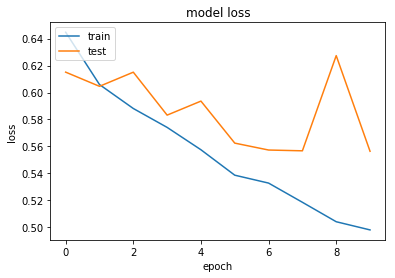

In [295]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [296]:
model_2_out_train = model2.predict([pad_question1_train,pad_question2_train],verbose=2,batch_size = 128)
model_2_out_test = model2.predict([pad_question1_test,pad_question2_test],verbose=2,batch_size = 128)

/opt/conda/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


In [297]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(pd.DataFrame(model_2_out_train), pd.DataFrame(train_label))
y_pred = clf.predict(pd.DataFrame(model_2_out_test))

In [298]:
from sklearn.metrics import accuracy_score
print("Accuracy is ", accuracy_score(test_label,y_pred)*100)

Accuracy is  65.8


In [299]:
count_true_1 = 0
count_false_1 = 0


for a,b in zip(test_label,y_pred):
    if a == 1:
        if b == 1:
            count_true_1 += 1
        else:
            count_false_1 += 1
            
print("Total number of actual similar question:" + str(sum(test_label)))
print("Total number of correctly clasified similar question:" + str(count_true_1))
print("Total number of incorrectly clasified similar question:" + str(count_false_1))

Total number of actual similar question:322
Total number of correctly clasified similar question:174
Total number of incorrectly clasified similar question:148


In [300]:
history = model2.fit([pad_question1_train,pad_question2_train], 
          [train_label],
          epochs=10, verbose=2,batch_size = 128,shuffle = True,validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
28s - loss: 0.4836 - val_loss: 0.5505
Epoch 2/10
28s - loss: 0.4719 - val_loss: 0.5502
Epoch 3/10
28s - loss: 0.4629 - val_loss: 0.5687
Epoch 4/10
28s - loss: 0.4464 - val_loss: 0.5452
Epoch 5/10
28s - loss: 0.4379 - val_loss: 0.5701
Epoch 6/10
28s - loss: 0.4247 - val_loss: 0.5586
Epoch 7/10
28s - loss: 0.4101 - val_loss: 0.5688
Epoch 8/10
28s - loss: 0.4019 - val_loss: 0.5953
Epoch 9/10
28s - loss: 0.3861 - val_loss: 0.5569
Epoch 10/10
28s - loss: 0.3958 - val_loss: 0.5485


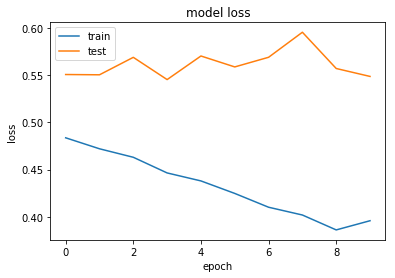

In [301]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [302]:
model_2_out_train = model2.predict([pad_question1_train,pad_question2_train],verbose=2,batch_size = 128)
model_2_out_test = model2.predict([pad_question1_test,pad_question2_test],verbose=2,batch_size = 128)

In [303]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(pd.DataFrame(model_2_out_train), pd.DataFrame(train_label))
y_pred = clf.predict(pd.DataFrame(model_2_out_test))

In [304]:
from sklearn.metrics import accuracy_score
print("Accuracy is ", accuracy_score(test_label,y_pred)*100)

Accuracy is  70.2


In [306]:
count_true_1 = 0
count_false_1 = 0


for a,b in zip(test_label,y_pred):
    if a == 1:
        if b == 1:
            count_true_1 += 1
        else:
            count_false_1 += 1
            
print("Total number of actual similar question:" + str(sum(test_label)))
print("Total number of correctly clasified similar question:" + str(count_true_1))
print("Total number of incorrectly clasified similar question:" + str(count_false_1))

Total number of actual similar question:322
Total number of correctly clasified similar question:177
Total number of incorrectly clasified similar question:145


In [312]:
history = model2.fit([pad_question1_train,pad_question2_train], 
          [train_label],
          epochs=10, verbose=2,batch_size = 128,shuffle = True,validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
28s - loss: 0.3823 - val_loss: 0.5958
Epoch 2/10
28s - loss: 0.3613 - val_loss: 0.5969
Epoch 3/10
28s - loss: 0.3548 - val_loss: 0.6002
Epoch 4/10
28s - loss: 0.3350 - val_loss: 0.6182
Epoch 5/10
28s - loss: 0.3278 - val_loss: 0.6029
Epoch 6/10
28s - loss: 0.3154 - val_loss: 0.6206
Epoch 7/10
28s - loss: 0.2989 - val_loss: 0.6815
Epoch 8/10
28s - loss: 0.2992 - val_loss: 0.6582
Epoch 9/10
27s - loss: 0.2832 - val_loss: 0.7511
Epoch 10/10
28s - loss: 0.2722 - val_loss: 0.7136


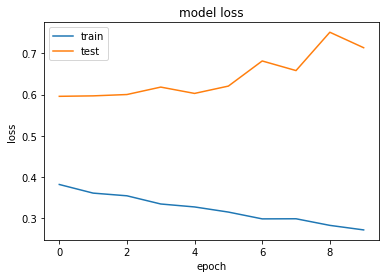

In [313]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [314]:
model_2_out_train = model2.predict([pad_question1_train,pad_question2_train],verbose=2,batch_size = 128)
model_2_out_test = model2.predict([pad_question1_test,pad_question2_test],verbose=2,batch_size = 128)

In [315]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(pd.DataFrame(model_2_out_train), pd.DataFrame(train_label))
y_pred = clf.predict(pd.DataFrame(model_2_out_test))

In [316]:
from sklearn.metrics import accuracy_score
print("Accuracy is ", accuracy_score(test_label,y_pred)*100)

Accuracy is  71.2


In [317]:
count_true_1 = 0
count_false_1 = 0


for a,b in zip(test_label,y_pred):
    if a == 1:
        if b == 1:
            count_true_1 += 1
        else:
            count_false_1 += 1
            
print("Total number of actual similar question:" + str(sum(test_label)))
print("Total number of correctly clasified similar question:" + str(count_true_1))
print("Total number of incorrectly clasified similar question:" + str(count_false_1))

Total number of actual similar question:322
Total number of correctly clasified similar question:170
Total number of incorrectly clasified similar question:152


** Observation **

Model 2 started overfitting data after 20 epoch. Number of coorectly identified same question decreased as seen above.